In [2]:
import os

import astropy.coordinates as coord
from astropy.io import fits
import astropy.table as at
import astropy.units as u
import h5py
import matplotlib as mpl
import matplotlib.pyplot as plt
%matplotlib inline
import numpy as np
from matplotlib.gridspec import GridSpec

from hq.config import Config
from hq.data import get_rvdata

from gala.mpl_style import laguna

import thejoker as tj

In [3]:
def fast_m2_min(m1, mf):
    return (2*mf + np.power(2,0.6666666666666666)*
      np.power(mf*(27*pow(m1,2) + 18*m1*mf + 2*np.power(mf,2) + 
          3*np.sqrt(3)*np.sqrt(np.power(m1,3)*(27*m1 + 4*mf))),0.3333333333333333) + 
     (2*mf*(6*m1 + mf))/
      np.power((27*np.power(m1,2)*mf)/2. + 9*m1*np.power(mf,2) + np.power(mf,3) + 
        (3*np.sqrt(3)*mf*np.sqrt(np.power(m1,3)*(27*m1 + 4*mf)))/2.,0.3333333333333333))/6.

In [4]:
figure_path = '../../tex/figures'
os.makedirs(figure_path, exist_ok=True)

In [5]:
c = Config.from_run_name('dr16-random')

In [6]:
allstar, allvisit = c.load_alldata()

In [7]:
binaries = at.QTable.read('../../catalogs/lnK0.0_logL4.6_metadata_gaia_starhorse.fits')

In [8]:
all_samples = at.Table.read('../../catalogs/lnK0.0_logL4.6_samples.hdf5')

# HACK: fix this by adding samples.__table_metadata__ or whatever to this file...
all_samples['P'] = all_samples['P'] * u.day
all_samples['e'] = all_samples['e'] * u.one
all_samples['omega'] = all_samples['omega'] * u.radian
all_samples['M0'] = all_samples['M0'] * u.radian
all_samples['s'] = all_samples['s'] * u.km/u.s
all_samples['K'] = all_samples['K'] * u.km/u.s
all_samples['v0'] = all_samples['v0'] * u.km/u.s
all_samples['ln_prior'] = all_samples['ln_prior'] * u.one
all_samples['ln_likelihood'] = all_samples['ln_likelihood'] * u.one

all_samples = at.QTable(all_samples)

In [27]:
rnd = np.random.RandomState(123)

nvis = 9
mask = ((binaries['n_visits'] == nvis) & 
        (binaries['baseline'] > 1000*u.day) &
        (binaries['baseline'] < 2000*u.day) &
        (~binaries['mcmc_completed']) & 
        (np.abs(binaries['VHELIO_AVG']) < 80) &
        (binaries['m2_min_5'] > 0.2*u.Msun))
mask.sum()

17

In [28]:
def get_stuff(apid):
    row = binaries[binaries['APOGEE_ID'] == apid]
    visits = allvisit[allvisit['APOGEE_ID'] == row['APOGEE_ID']]
    data = get_rvdata(visits)

    samples_tbl = all_samples[all_samples['APOGEE_ID'] == row['APOGEE_ID']]
    _tbl = samples_tbl.copy()
    _tbl.remove_columns(['APOGEE_ID', 'm_f'])
    samples = tj.JokerSamples(_tbl)
    samples.tbl.meta['t0'] = data.t0

    m1s = rnd.normal(row['mass'], row['mass_err'], size=len(samples_tbl))
    m2_mins = fast_m2_min(m1s, samples_tbl['m_f']) * u.Msun
    
    return data, samples, m2_mins

2M08132628+2837152
2M11062363+4626401
2M07404891+3751106
2M07402471+3811039
2M07344032+3712249


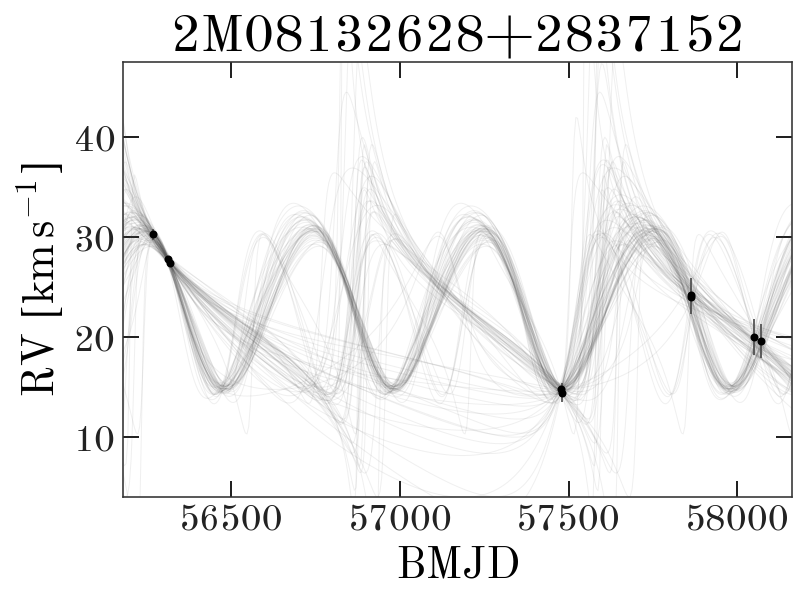

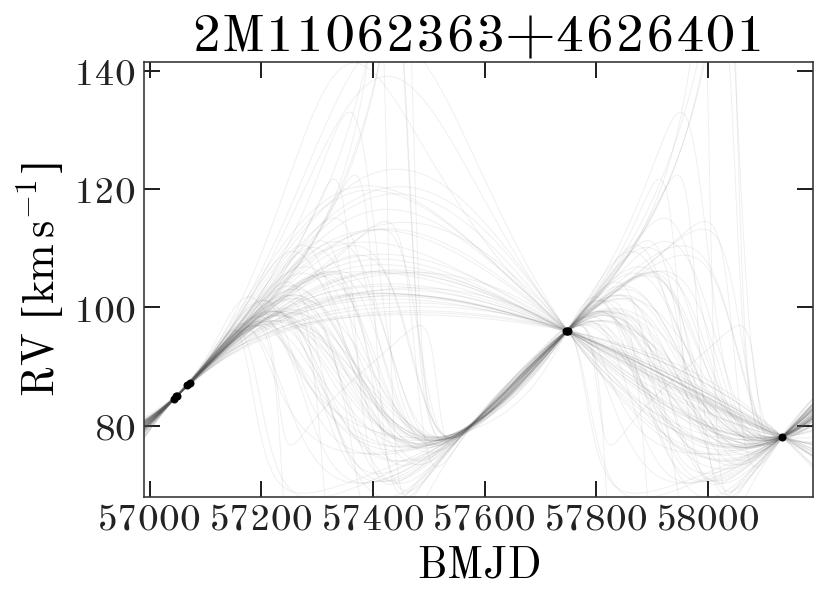

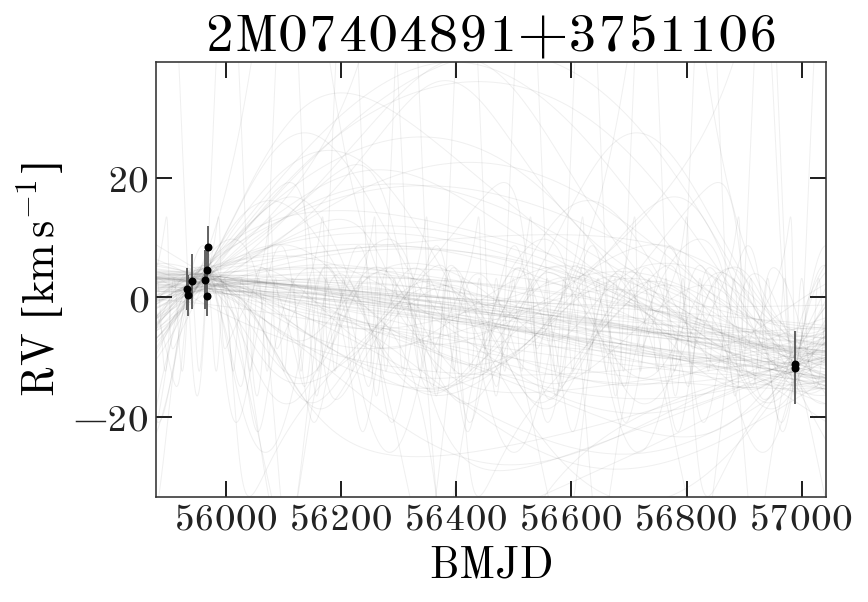

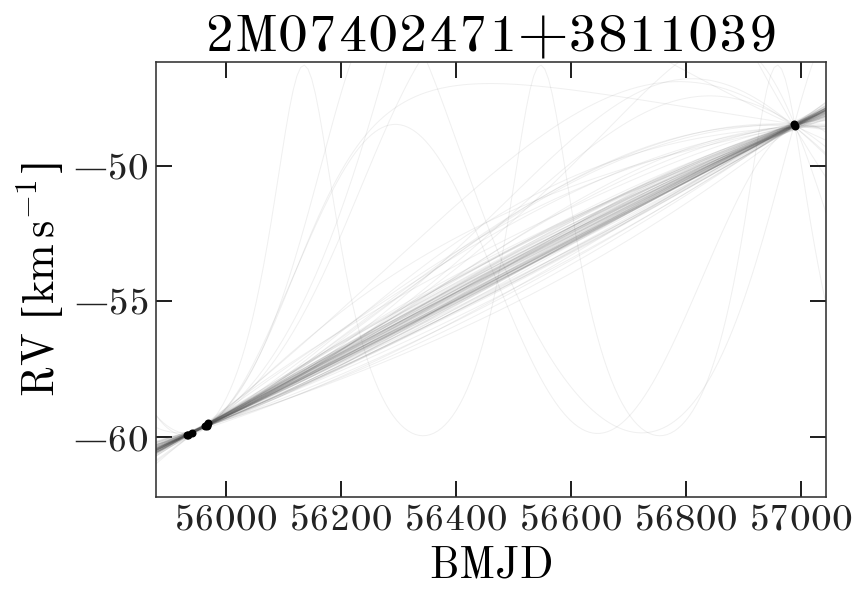

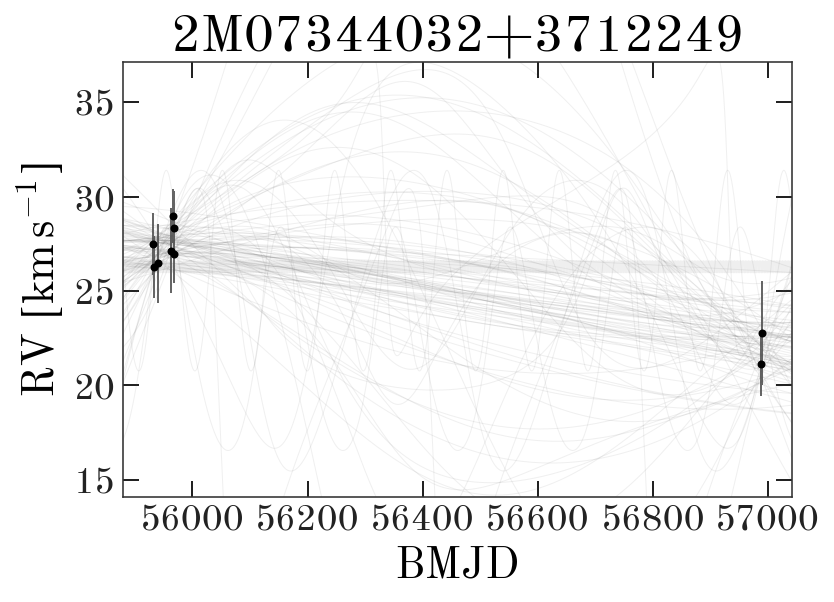

In [30]:
# for apid in binaries['APOGEE_ID'][mask][:5]:
#     data, samples, _ = get_stuff(apid)
    
#     plt.figure()
#     fig = tj.plot_rv_curves(samples[:100], data=data)
#     fig.axes[0].set_title(apid)
#     print(apid)

### Short baseline:

In [75]:
example_ids = [
    '2M02484723+0719196',
    '2M05201489+4250312',
    '2M03443349+5038480', # '2M03443349+5038480',
    '2M09193551+3429514'
]

max_baseline = binaries[np.isin(binaries['APOGEE_ID'].astype(str), 
                                example_ids)]['baseline'].max()
max_baseline

<Quantity 83.79669132 d>

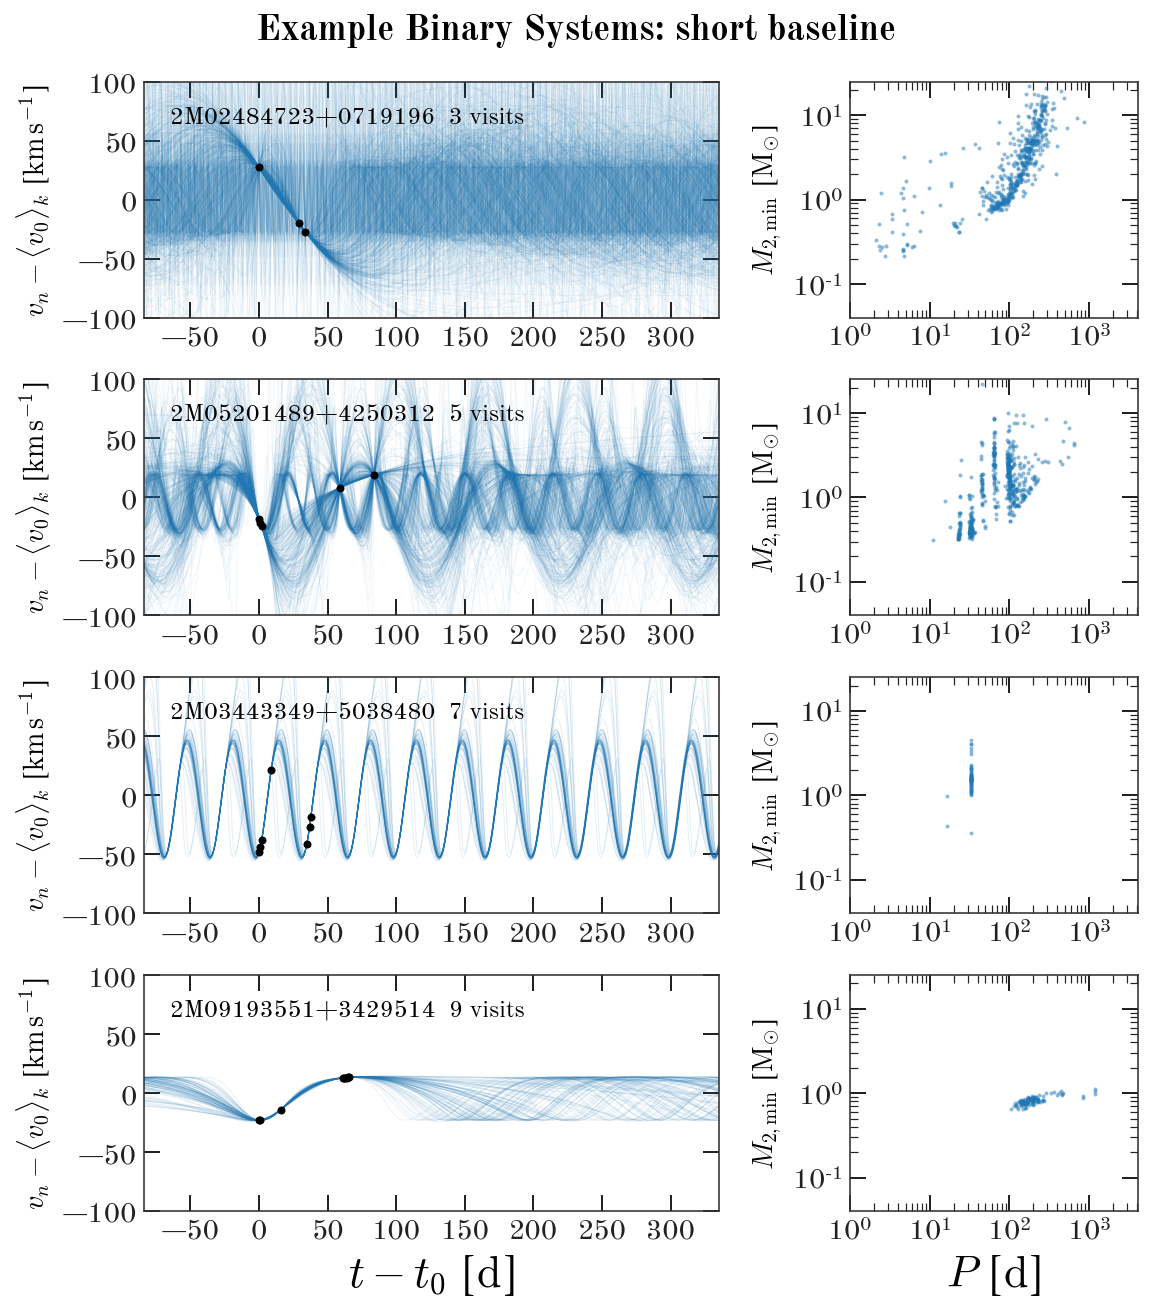

In [76]:
fig = plt.figure(figsize=(8., 9), constrained_layout=True)
gs = GridSpec(4, 6, figure=fig)

for i, apid in enumerate(example_ids):
    data, samples, m2_mins = get_stuff(apid)

    ax = fig.add_subplot(gs[i, :4])
    
    t_grid = np.linspace(-1 * max_baseline.to_value(u.day), 
                         4 * max_baseline.to_value(u.day),
                         16384) * u.day
    
    data = tj.RVData(t=data.t, rv=data.rv-np.mean(samples['v0']), 
                     rv_err=data.rv_err)
    samples['v0'] = samples['v0'] - np.mean(samples['v0'])
    
    _ = tj.plot_rv_curves(samples, data=data, t_grid=data.t0 + t_grid,
                          plot_kwargs=dict(color='tab:blue', rasterized=True), 
                          relative_to_t0=True)
    
    ax.text(-65, 80, f'{apid}  {len(data)} visits', 
            ha='left', va='top', fontsize=12)
    
    ax.set_xticks(np.arange(-50, t_grid.max().value, 50))
    ax.set_yticks(np.arange(-100, 100+1e-3, 50))
    
    if i == (len(example_ids)-1):
        ax.set_xlabel(f'$t - t_0$ [{u.day:latex_inline}]')
    else:
        ax.set_xlabel('')
    
    ax.set_ylabel(rf'$v_n - \langle v_0 \rangle_k$ [{u.km/u.s:latex_inline}]', fontsize=14)
    
    ax.set_xlim(t_grid.min().value, t_grid.max().value)
    ax.set_ylim(-100, 100)
    
    ax.tick_params(labelsize=14)
        
    # ---

    ax = fig.add_subplot(gs[i, 4:])

    ax.plot(samples['P'], m2_mins, 
            marker='o', ls='none', 
            ms=2., mew=0, alpha=0.5,
            rasterized=True)

    ax.set_xscale('log')
    ax.set_yscale('log')

    ax.set_xticks(10 ** np.arange(0, 4.+1e-3, 1))
    ax.set_xticks(np.concatenate([[j * 10**i for j in range(1, 10)] 
                                  for i in np.arange(0, 4+1e-3)]),
                  minor=True)
    ax.set_yticks(10 ** np.arange(-1, 1+1e-3, 1))
    ax.set_yticks(np.concatenate([[j * 10**i for j in range(1, 10)] 
                                  for i in np.arange(-1, 1+1e-3)]),
                  minor=True)
    
    ax.set_xlim(1, 4096)
    ax.set_ylim(4e-2, 25)

    ax.set_ylabel(rf'$M_{{2, {{\rm min}}}}$ [{u.Msun:latex_inline}]', fontsize=14)
    
    if i == (len(example_ids)-1):
        ax.set_xlabel(f'$P$ [{u.day:latex_inline}]')

    ax.tick_params(labelsize=14)
        
fig.suptitle('Example Binary Systems: short baseline', fontsize=18, fontweight='bold')
        
fig.set_constrained_layout_pads(w_pad=0.1)

# fig.savefig(os.path.join(figure_path, 'example-binaries-short.pdf'), dpi=200)
fig.savefig(os.path.join(figure_path, 'example-binaries-short-placeholder.png'), dpi=100)

### Long baseline

In [77]:
example_ids = [
    '2M09010280+0237517',
    '2M00333448+5533244',
    '2M03423566+3217198',
    '2M11062363+4626401'
]

max_baseline = binaries[np.isin(binaries['APOGEE_ID'].astype(str), 
                                example_ids)]['baseline'].max()
max_baseline

<Quantity 1936.66282321 d>

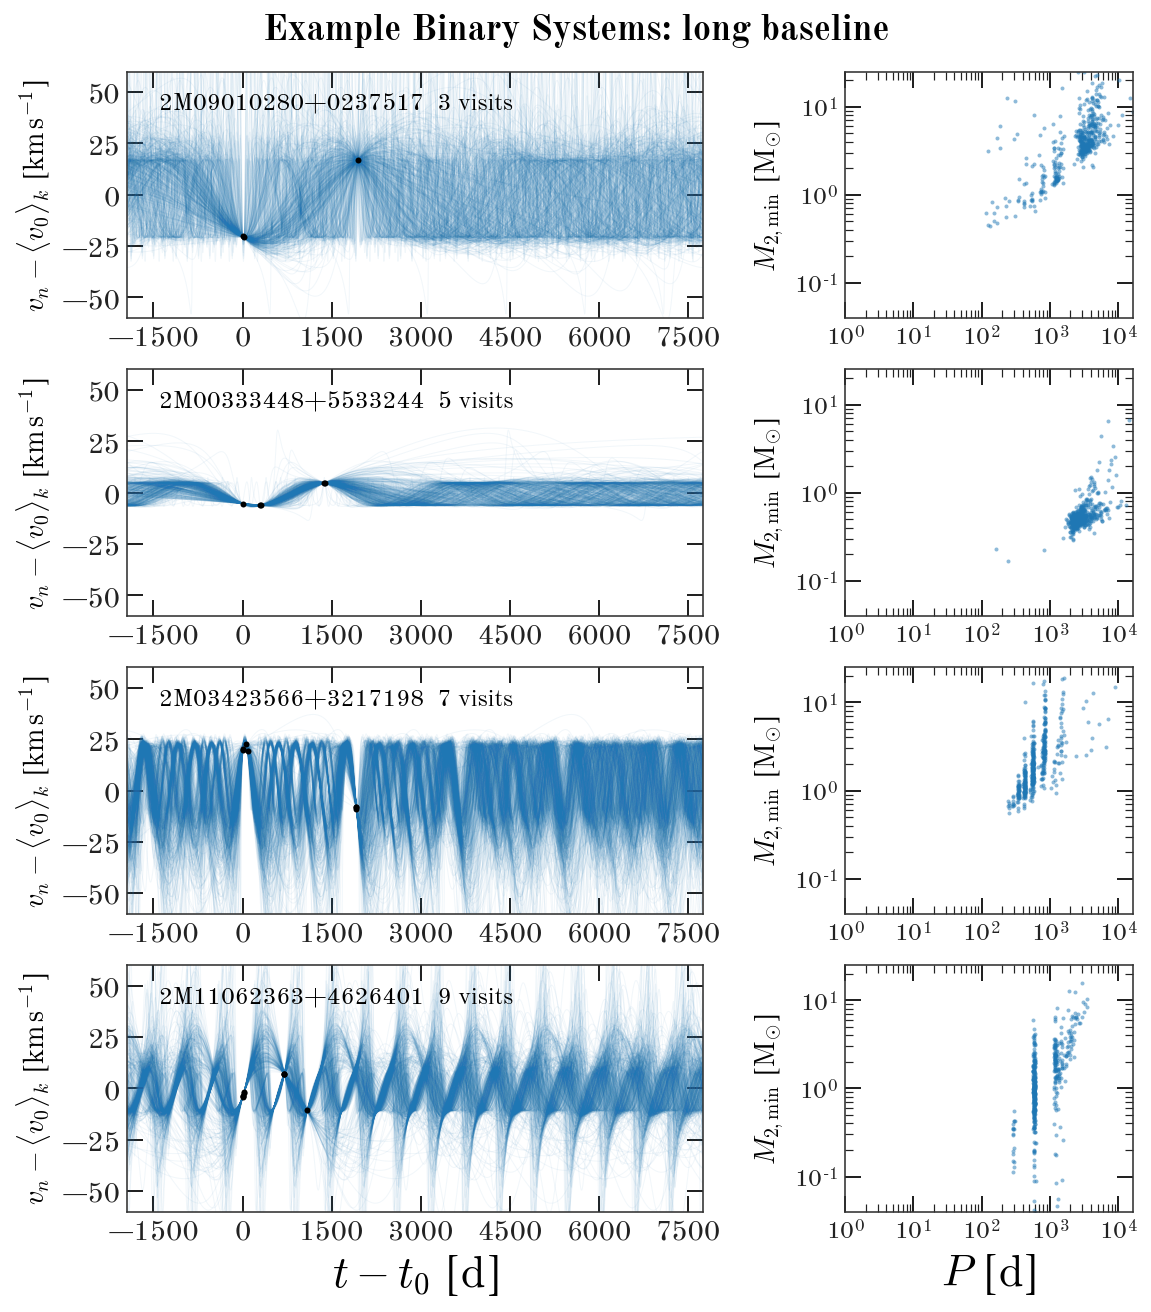

In [78]:
fig = plt.figure(figsize=(8., 9), constrained_layout=True)
gs = GridSpec(4, 6, figure=fig)

for i, apid in enumerate(example_ids):
    data, samples, m2_mins = get_stuff(apid)
    m2_mins = m2_mins[samples['P'] > 100*u.day]
    samples = samples[samples['P'] > 100*u.day]

    ax = fig.add_subplot(gs[i, :4])
    
    t_grid = np.linspace(-1 * max_baseline.to_value(u.day), 
                         4 * max_baseline.to_value(u.day),
                         16384) * u.day
    
    data = tj.RVData(t=data.t, rv=data.rv-np.mean(samples['v0']), 
                     rv_err=data.rv_err)
    samples['v0'] = samples['v0'] - np.mean(samples['v0'])
    
    _ = tj.plot_rv_curves(samples, data=data, t_grid=data.t0 + t_grid,
                          plot_kwargs=dict(color='tab:blue', rasterized=True), 
                          data_plot_kwargs=dict(markersize=3),
                          relative_to_t0=True)
    
    ax.text(-1400, 50, f'{apid}  {len(data)} visits', 
            ha='left', va='top', fontsize=12)
    
    ax.set_xticks(np.arange(-1500, t_grid.max().value, 1500))
    ax.set_yticks(np.arange(-100, 100+1e-3, 25))
    
    if i == (len(example_ids)-1):
        ax.set_xlabel(f'$t - t_0$ [{u.day:latex_inline}]')
    else:
        ax.set_xlabel('')
    
    ax.set_ylabel(rf'$v_n - \langle v_0 \rangle_k$ [{u.km/u.s:latex_inline}]', fontsize=14)
    
    ax.set_xlim(t_grid.min().value, t_grid.max().value)
    ax.set_ylim(-60, 60)
    
    ax.tick_params(labelsize=14)
        
    # ---

    ax = fig.add_subplot(gs[i, 4:])

    ax.plot(samples['P'], m2_mins, 
            marker='o', ls='none', 
            ms=2., mew=0, alpha=0.5,
            rasterized=True)

    ax.set_xscale('log')
    ax.set_yscale('log')

    ax.set_xticks(10 ** np.arange(0, 4.+1e-3, 1))
    ax.set_xticks(np.concatenate([[j * 10**i for j in range(1, 10)] 
                                  for i in np.arange(0, 4+1e-3)]),
                  minor=True)
    ax.set_yticks(10 ** np.arange(-1, 1+1e-3, 1))
    ax.set_yticks(np.concatenate([[j * 10**i for j in range(1, 10)] 
                                  for i in np.arange(-1, 1+1e-3)]),
                  minor=True)
    
    ax.set_xlim(1, 16384)
    ax.set_ylim(4e-2, 25)

    ax.set_ylabel(rf'$M_{{2, {{\rm min}}}}$ [{u.Msun:latex_inline}]', fontsize=14)
    
    if i == (len(example_ids)-1):
        ax.set_xlabel(f'$P$ [{u.day:latex_inline}]')

    ax.tick_params(labelsize=12)
        
fig.suptitle('Example Binary Systems: long baseline', fontsize=18, fontweight='bold')
        
fig.set_constrained_layout_pads(w_pad=0.1)

# fig.savefig(os.path.join(figure_path, 'example-binaries-long.pdf'), dpi=200)
fig.savefig(os.path.join(figure_path, 'example-binaries-long-placeholder.png'), dpi=100)